## LOAD DATA

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 3.4MB 12.8MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import collections
import pathlib
import re
import string

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/main_lines_verses.csv")

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
df.head()

,artist_name,line
42982,Drake & Giggs,You don't know nothin' 'bout me
77110,Ice Cube,"Gorilla niggas, here come King Kong"
39850,Prophet,Of almost every hot rapper in the past 20 years
65740,Guru,"Hit man, with ice in his veins"
64094,Guru,One of the meanest and the cleanest


In [ ]:
df['artist_name'].value_counts().sort_index()

 2Pac & Tyrone Wrice     5
 Drake                  22
 Goldie Loc             79
 King Gordy             32
 Method Man             17
                        ..
iNTeLL                  16
mark curry              18
p. diddy over Hook       8
stic.man, dead prez      9
will.i.am               13
Name: artist_name, Length: 1262, dtype: int64

In [ ]:
# df.replace("Jay-Z", "JAY-Z", inplace=True)
# df.replace("KRS-One", "KRS-ONE", inplace=True)
# df.replace("LL Cool J", "L.L. Cool J", inplace=True)
# df.replace("Royce da 5'9", "Royce Da 5'9", inplace=True)
df.replace("Notorious B.I.G.", "The Notorious B.I.G.", inplace=True)
df = df.groupby('artist_name').filter(lambda x : len(x)>1000)
df = df[df['line'].apply(lambda x: len(x.split(" ")) > 3)]

In [ ]:
list = ['The Notorious B.I.G.', 'Ice Cube', 'Nas', '2Pac', 'Method Man', 'Eminem',
        'Snoop Dogg', 'DMX', 'Dr. Dre', 'GZA', 'The Notorious B.I.G.', 'RZA']
df = df[df['artist_name'].isin(list)]

In [ ]:
df['artist_name'].value_counts()

Eminem                  8377
Ice Cube                4381
Nas                     3821
2Pac                    3775
Method Man              3331
The Notorious B.I.G.    2695
Snoop Dogg              2626
DMX                     2562
Dr. Dre                 2235
GZA                     2033
RZA                     1762
Name: artist_name, dtype: int64

In [ ]:
lyrics_features = df['line']
lyrics_labels = df.pop('artist_name')

In [ ]:
lyrics_labels

77110                 Ice Cube
939                       2Pac
50605                   Eminem
72620                      GZA
175401              Snoop Dogg
                  ...         
79735                 Ice Cube
49364                   Eminem
29962     The Notorious B.I.G.
178956                 Dr. Dre
32563                 Ice Cube
Name: artist_name, Length: 37598, dtype: object

In [ ]:
set(lyrics_labels)

{'2Pac',
 'DMX',
 'Dr. Dre',
 'Eminem',
 'GZA',
 'Ice Cube',
 'Method Man',
 'Nas',
 'RZA',
 'Snoop Dogg',
 'The Notorious B.I.G.'}

In [ ]:
len(set(lyrics_labels))

11

In [ ]:
lyrics_labels = lyrics_labels.astype("category")

In [ ]:
artist_ids = dict(enumerate(lyrics_labels.cat.categories))
artist_ids

{0: '2Pac',
 1: 'DMX',
 2: 'Dr. Dre',
 3: 'Eminem',
 4: 'GZA',
 5: 'Ice Cube',
 6: 'Method Man',
 7: 'Nas',
 8: 'RZA',
 9: 'Snoop Dogg',
 10: 'The Notorious B.I.G.'}

In [ ]:
lyrics_labels = lyrics_labels.cat.codes

In [ ]:
lyrics_labels

77110      5
939        0
50605      3
72620      4
175401     9
          ..
79735      5
49364      3
29962     10
178956     2
32563      5
Length: 37598, dtype: int8

In [ ]:
len(set(lyrics_labels))

11

In [ ]:
lyrics_ds = tf.data.Dataset.from_tensor_slices((lyrics_features, lyrics_labels))

In [ ]:
BUFFER_SIZE = 38000
BATCH_SIZE = 64
VALIDATION_SIZE = 3000

In [ ]:
all_labeled_data = lyrics_ds.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

for text, label in all_labeled_data.take(10):
  print("Line: ", text.numpy())
  print("Artist:", label.numpy())

Line:  b"'Cause I know niggas is hard-headed but I ain't got the patience"
Artist: 1
Line:  b'So go write whatever blog, messiness is not ever the God'
Artist: 7
Line:  b'Dug that stank bitch back out and then played her'
Artist: 6
Line:  b'Yo watch my neck just twist'
Artist: 3
Line:  b'It all makes sense when I look into her eyes, oh, no'
Artist: 3
Line:  b"Think about it now, that's damn near 1.5"
Artist: 10
Line:  b'I blow hash smoke through my nasal'
Artist: 8
Line:  b"Bad Boy bitin' Nas album cover, wait"
Artist: 7
Line:  b'In a fat-ass crib with thousands of kids'
Artist: 6
Line:  b'You bound to get fucked you trick ass snitch'
Artist: 9


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

### RNN CLASSIFIER

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
VOCAB_SIZE = 8000

In [ ]:
train_dataset = all_labeled_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
test_dataset = all_labeled_data.take(VALIDATION_SIZE)

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print('lebal: ', label.numpy()[:3])

texts:  [b"Don't know love, can't show love"
 b"In a '61 Chevy, still heavy in this game"
 b'I got these corny wannabe diss song kings on the radio']
lebal:  [1 0 7]


In [ ]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'i', 'a', 'to', 'and', 'you', 'my', 'in', 'it',
       'me', 'im', 'on', 'of', 'with', 'that', 'like', 'your', 'up'],
      dtype='<U20')

In [ ]:
encoded_example = encoder(example)[:10].numpy()
encoded_example

array([[  30,   46,   95,   75,  169,   95,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   9,    4, 7059, 3895,   84,  840,    9,   25,  134,    0,    0,
           0,    0,    0,    0],
       [   3,   28,   77, 3868, 3990, 1172,  493, 1658,   13,    2, 1064,
           0,    0,    0,    0],
       [2310,    5,   63,    4,  200, 1058,  869,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   4,  591,  734, 1055,    2,  174,   15,    8, 1436,    0,    0,
           0,    0,    0,    0],
       [ 113,    7,   46, 2441,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  12, 2110, 1674,    8, 3112,   20, 6386,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   6,    9,    8,  728,    3,  192,  242,  622,    0,    0,    0,
           0,    0,    0,    0],
       [   6,  223,    4, 6529,   13, 2343,   22, 3228,    0,    0,    0,
           0,    0,    0,    0],
       [ 540, 4222,   22, 1403,    6,

In [ ]:
for n in range(10):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Don't know love, can't show love"
Round-trip:  dont know love cant show love         

Original:  b"In a '61 Chevy, still heavy in this game"
Round-trip:  in a 61 chevy still heavy in this game      

Original:  b'I got these corny wannabe diss song kings on the radio'
Round-trip:  i got these corny wannabe diss song kings on the radio    

Original:  b'*sniff* to make a long story short'
Round-trip:  sniff to make a long story short        

Original:  b'A buck 50 across the face with my razor'
Round-trip:  a buck 50 across the face with my razor      

Original:  b'Yeah, you know what\xe2\x80\x99s happenin\xe2\x80\x99'
Round-trip:  yeah you know what’s [UNK]          

Original:  b"I'm dropping flavor, my behavior is hereditary"
Round-trip:  im dropping flavor my behavior is hereditary        

Original:  b"And in my dreams I hear motherfuckers screamin'"
Round-trip:  and in my dreams i hear motherfuckers screamin       

Original:  b"(And he's a felon) On parole for rob

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11)
])


In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00051638]


In [ ]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00051639]


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=30,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/30
541/541 [==============================] - 13s 24ms/step - loss: 1.5340 - accuracy: 0.4861 - val_loss: 2.1176 - val_accuracy: 0.3234
Epoch 2/30
541/541 [==============================] - 13s 24ms/step - loss: 1.4979 - accuracy: 0.4987 - val_loss: 2.1432 - val_accuracy: 0.3260
Epoch 3/30
541/541 [==============================] - 13s 24ms/step - loss: 1.4662 - accuracy: 0.5121 - val_loss: 2.1553 - val_accuracy: 0.3286
Epoch 4/30
541/541 [==============================] - 13s 24ms/step - loss: 1.4348 - accuracy: 0.5249 - val_loss: 2.1762 - val_accuracy: 0.3276
Epoch 5/30
541/541 [==============================] - 13s 24ms/step - loss: 1.4053 - accuracy: 0.5351 - val_loss: 2.2183 - val_accuracy: 0.3302
Epoch 6/30
541/541 [==============================] - 13s 24ms/step - loss: 1.3748 - accuracy: 0.5476 - val_loss: 2.2093 - val_accuracy: 0.3302
Epoch 7/30
541/541 [==============================] - 13s 24ms/step - loss: 1.3460 - accuracy: 0.5597 - val_loss: 2.2333 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 0s 7ms/step - loss: 3.2246 - accuracy: 0.3333
Test Loss: 3.2245752811431885
Test Accuracy: 0.3333333432674408


(0.0, 3.347296339273453)

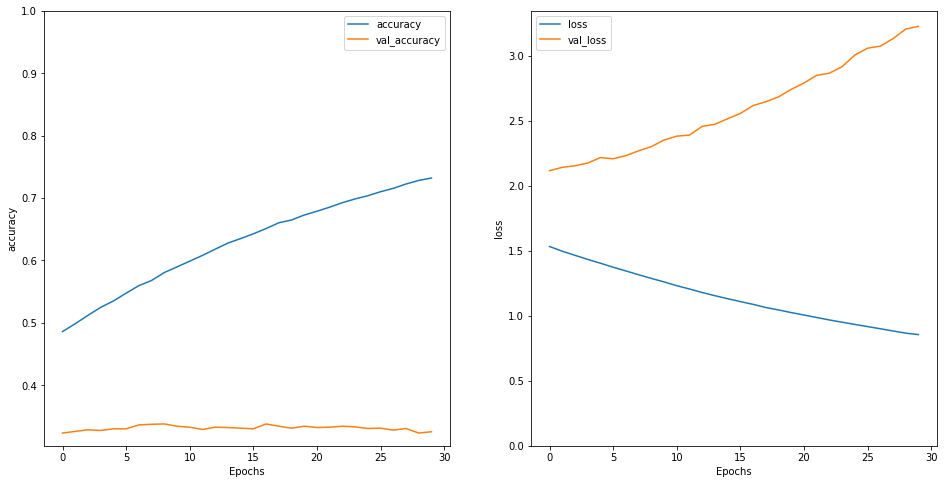

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(11)
])


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=30,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/30
541/541 [==============================] - 25s 46ms/step - loss: 2.2907 - accuracy: 0.2231 - val_loss: 2.2294 - val_accuracy: 0.2484
Epoch 2/30
541/541 [==============================] - 21s 39ms/step - loss: 2.2142 - accuracy: 0.2443 - val_loss: 2.1762 - val_accuracy: 0.2688
Epoch 3/30
541/541 [==============================] - 21s 39ms/step - loss: 2.1486 - accuracy: 0.2621 - val_loss: 2.1421 - val_accuracy: 0.2781
Epoch 4/30
541/541 [==============================] - 22s 40ms/step - loss: 2.0799 - accuracy: 0.2858 - val_loss: 2.1174 - val_accuracy: 0.2719
Epoch 5/30
541/541 [==============================] - 22s 40ms/step - loss: 2.0179 - accuracy: 0.3074 - val_loss: 2.0928 - val_accuracy: 0.2734
Epoch 6/30
541/541 [==============================] - 21s 40ms/step - loss: 1.9555 - accuracy: 0.3244 - val_loss: 2.0705 - val_accuracy: 0.2797
Epoch 7/30
541/541 [==============================] - 22s 40ms/step - loss: 1.8945 - accuracy: 0.3433 - val_loss: 2.0798 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 1s 11ms/step - loss: 2.8640 - accuracy: 0.3200
Test Loss: 2.8639514446258545
Test Accuracy: 0.3199999928474426


In [ ]:
sample_text = ('So if I said I never did drugs, that would mean I lie and get fucked more than the President does')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-3.4415479  -0.28796932 -0.5231788   4.2337065  -2.0657156  -1.6915143
  -1.562889   -2.0644145  -2.065338   -0.9423143  -2.6981914 ]]


In [ ]:
sample_text = ("Big Poppa smash fools, bash fools")
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[ 0.16037017 -0.3657387  -0.5233064  -1.8952279  -2.8392837   0.81070495
   0.44565812 -0.1835935  -2.6383808   0.39324844  2.5171375 ]]
